# Imports

In [26]:
%reload_ext autoreload

%autoreload 2
import video_processing as vp
import librain as lb
import fnames
import numpy
from roipoly import RoiPoly 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
import sys
from joblib import Parallel, delayed, cpu_count
from fastdtw import fastdtw
import time

from scipy import signal
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial.distance import correlation, euclidean #, pdist, canberra
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

import warnings

warnings.filterwarnings('ignore')

# File Paths and Constants

In [33]:
path = "B:/Dual/" # location of "date" folders

direc = lb.Data(path)

dates = ['20190808']

# experiment_numbers = [1, 2, 3, 4, 5, 6, 7, 8]
# experiment_numbers = [1, 3, 5, 7]
# experiment_numbers = [2, 4, 6, 8]
experiment_numbers = [1]


TRUE_FRAMERATE = 28.815


# Correlation vs Frequency and Time

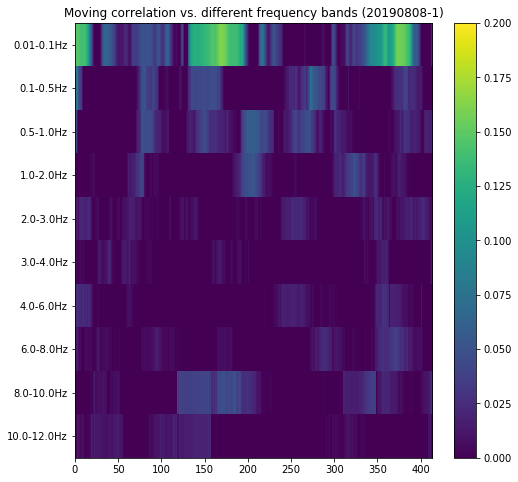

In [35]:
correlation_heatmap = []
correlation_heatmap = numpy.empty([10, 10956, 6])

count = 0
for date in dates:
    for exp_num in experiment_numbers:
        
        EXP = direc.experiment(date, exp_num)
        
        corr_file = direc.file(
            exp_folder=EXP, 
            fname="freq split ws=1000"
        )
        
        temp_corr = numpy.load(corr_file)       
        correlation_heatmap[:, :, count] = temp_corr[:,0:numpy.shape(correlation_heatmap)[1]]

mean_correlation_heatmap = numpy.mean(correlation_heatmap, axis=2)




frequency_bands = (
    0.01,
    0.1,
    0.5,
    1.0,
    2.0,
    3.0,
    4.0,
    6.0,
    8.0,
    10.0,
    12.0,
)

frequency_labels = []
for i, (low, high) in enumerate(zip(frequency_bands, frequency_bands[1:])):
    frequency_labels.append(
        str(low) + "-" + str(high) + "Hz"
    )


plt.figure(figsize=(8, 8))
plt.title(
    "Moving correlation vs. different frequency bands ({}-{})".format(date, exp_num)
)
y_ticks = numpy.arange(numpy.shape(mean_correlation_heatmap)[0])+0.5
y_ticks = numpy.flipud(y_ticks)
plt.imshow(
    mean_correlation_heatmap, 
    cmap='viridis', 
    extent=[0,413,0,10],
    aspect='auto', 
    vmin=-0, 
    vmax=0.2
)
plt.yticks(y_ticks, frequency_labels)
plt.colorbar()

# Trial Shuffling 20190808

In [28]:
date = '20190808'
experiment_numbers = [1, 2, 3, 4, 5, 6, 7, 8]

# filter parameters
fs = TRUE_FRAMERATE
order = 3
frequency_bands = (
    0.01,
    0.1,
    0.5,
    1.0,
    2.0,
    3.0,
    4.0,
    6.0,
    8.0,
    10.0,
    12.0,
)

# filter definition
def butter_bandpass_filter(
    data, cutoff_low, cutoff_high, fs, order=5
):
    b, a = butter_bandpass(
        cutoff_low, cutoff_high, fs, order=order
    )
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass(cutoff_low, cutoff_high, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff_low = cutoff_low / nyq
    normal_cutoff_high = cutoff_high / nyq
    Wn = [normal_cutoff_low, normal_cutoff_high]
    b, a = signal.butter(
        order, Wn, btype="bandpass", analog=False
    )
    return b, a

# initialize correlation parameters
window_size = 1000
correlation_heatmap = numpy.empty(
    [len(frequency_bands)-1, 11956-window_size, len(experiment_numbers)])


# set up flag for shuffling trials while maintaining mouse pairs
# note the following experiments use same mouse pairs 
# date: 20190808 experiments: (1,2), (3,4), (5,6), (7,8)
flag =  1

for exp_num in experiment_numbers:      
    
    # shuffle trials
    EXP_left = direc.experiment(date, exp_num)
    EXP_right = direc.experiment(date, exp_num + flag)
    
    # load global signals
    left_gs_file = direc.file(exp_folder=EXP_left, fname="left global")              
    right_gs_file = direc.file(exp_folder=EXP_right, fname="right global")
    left_gs = numpy.load(left_gs_file)
    right_gs = numpy.load(right_gs_file)
    
    # make sure signals are same length
    left_gs = left_gs[0:11956, 0]
    right_gs = right_gs[0:11956, 0]
    
#     plt.figure()
#     plt.plot(left_gs)
#     plt.plot(right_gs)
#     throwerrorhere
    
    # filter global signals
    frequency_labels = []
#     plt.figure()
    for i, (low, high) in enumerate(zip(frequency_bands, frequency_bands[1:])):
        frequency_labels.append(
            str(low) + "-" + str(high) + "Hz"
        )
        s1 = butter_bandpass_filter(
            left_gs, low, high, fs, order
        )
        s2 = butter_bandpass_filter(
            right_gs, low, high, fs, order
        )
        


#         plt.plot(s1)


#         print(low)
#         print(high)
#         print(1 - correlation(s1, s2))
#         del s1, s2
        
        # correlation inside moving window at current frequency band
        for j in range(len(s1) - window_size):
            correlation_heatmap[i, j, exp_num-1] = 1 - correlation(
                s1[j : j + window_size], s2[j : j + window_size])
   
    # switch flag
    flag = -flag
    


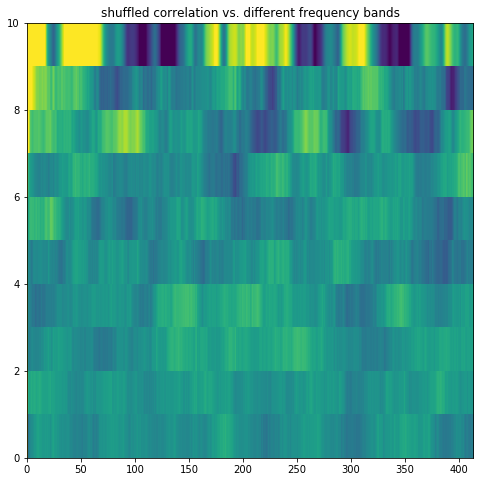

In [24]:
mean_correlation_heatmap = numpy.mean(correlation_heatmap, axis=2)
y_ticks = numpy.arange(mean_correlation_heatmap.shape[0])+0.5
y_ticks = numpy.flipud(y_ticks)
plt.figure(figsize=(8, 8))
plt.title("shuffled correlation vs. different frequency bands")
plt.imshow(
    mean_correlation_heatmap, 
    cmap='viridis', 
    extent=[0,413,0,10],
    aspect='auto', 
    vmin=-0.2, 
    vmax=0.2
)

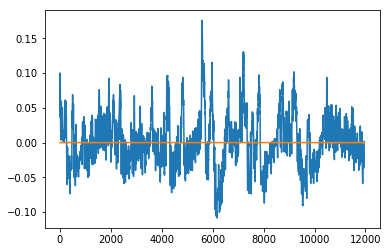

In [6]:
plt.figure()
plt.plot(left_gs)
filt = butter_bandpass_filter(
            left_gs, 0.01, 0.11, fs, order
        )
plt.plot(filt)

In [16]:
# print(fs)
# print(correlation_heatmap)
print(numpy.shape(correlation_heatmap))
# plt.figure()
# plt.imshow(numpy.mean(correlation_heatmap, axis=2))
print(numpy.shape(test))

(10, 10956)
(10, 10956)


In [181]:
import os
fname = 'left gsr'
dd = os.path.join(EXP, "")  
for root, dirs, files in os.walk(dd):
    for f in files:
        if 'gsr' in f and fname == 'left gsr':
            print(str(os.path.join(root, f)))

B:\Dual\20190808\Experiment_1\Derivatives\left_mouse_gsr_frames.raw
B:\Dual\20190808\Experiment_1\Derivatives\right_mouse_gsr_frames.raw


# Normalization of brain data (scrap analysis)

In [118]:
WIDTH=256
HEIGHT=256
SIGMA=2

path = "B:/Dual/" # location of "date" folders

direc = lb.Data(path)

date = '20190808'

EXP = direc.experiment(date, exp_num=7)

l_mouse_processed_file = direc.file(
    exp_folder=EXP, 
    fname="left green 0.01-12.0Hz",
    subfolder="Derivatives"
)

l_mouse_frames = vp.extract_RAW_frames(
    l_mouse_processed_file,
    WIDTH,
    HEIGHT,
    num_channels=1,
    dtype='float32'
)
l_mouse_frames[numpy.where(l_mouse_frames == -numpy.inf)] = -1

for i in range(l_mouse_frames.shape[0]):
    l_mouse_frames[i] = gaussian_filter(l_mouse_frames[i], SIGMA)                                      
l_mouse_frames = vp.downsample(l_mouse_frames, (64, 64))

l_mask_file = direc.file(
    exp_folder=EXP, 
    fname='LM mask'
)

l_mouse_mask = numpy.load(l_mask_file)

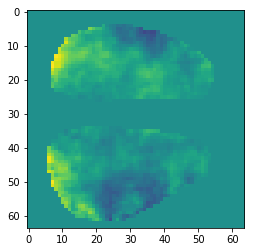

In [134]:
test = numpy.multiply(l_mouse_frames, l_mouse_mask[None, :, :])
maxes = numpy.max(numpy.max(abs(test), axis=2),axis=1)

test = numpy.divide(test, maxes[:, None, None]) + 1


plt.figure()
plt.imshow(test[1000,:,:], vmin=0, vmax = 2)
# print(numpy.shape(l_mouse_frames))

In [135]:
res = lb.Output(direc.experiment(date, exp_num=7))

norm_fname = res.saveas(
    path=EXP,
    suffix="normalized_left_green",
    f_out=test,
    ftype="raw",
    dtype='float32',
    save=True
)

Saved as normalized_left_green.raw


In [178]:
print(EXP)

B:\Dual\20190808\Experiment_7
